In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from shapely.geometry import Point

import numpy as np

import math

import seaborn as sns

In [2]:
# Load Excel file
df = pd.read_excel('Data/Turbines_At_Whitelee_Wind_Farm.xlsx')

# Print the contents of the Excel file to examine the data
print(df.head())

   Number   Latitude  Longitude    Altitude
0       1  55.689156  -4.358035  252.099340
1       2  55.686629  -4.351856  252.848013
2       3  55.695239  -4.363345  246.184076
3       4  55.693418  -4.355582  253.050163
4       5  55.685945  -4.341407  253.846623


In [3]:
# Load the .dat file containing the optimized grid layout
file_path_optimised_layout = 'Data/MaxWInd.dat'
optimized_grid_flat = np.loadtxt(file_path_optimised_layout)

# Reshape the 1D array into a 2D grid with dimensions 58x73
grid_rows = 58
grid_cols = 73
optimized_grid = optimized_grid_flat.reshape((grid_rows, grid_cols))

# Display the shape to confirm
optimized_grid.shape

optimized_grid_df = pd.DataFrame(optimized_grid)

In [4]:
# Extract latitude and longitude
latitudes = df['Latitude']
longitudes = df['Longitude']

# Calculate latitude and longitude ranges
lat_min, lat_max = latitudes.min(), latitudes.max()
lon_min, lon_max = longitudes.min(), longitudes.max()

# Create an empty list to store the latitude and longitude of turbines
optimized_coordinates = []

# Traverse the layout matrix to find all turbine locations
for row_idx in range(grid_rows):
    for col_idx in range(grid_cols):
        if optimized_grid[row_idx, col_idx] == 1:
            # Calculate the corresponding latitude and longitude
            lat = lat_min + (lat_max - lat_min) * row_idx / (grid_rows - 1)
            lon = lon_min + (lon_max - lon_min) * col_idx / (grid_cols - 1)
            optimized_coordinates.append((lat, lon))

# Convert results to DataFrame
optimized_df = pd.DataFrame(optimized_coordinates, columns=['Latitude', 'Longitude'])

# Output results
optimized_df.head()

,Latitude,Longitude
0,55.635065,-4.350912
1,55.635065,-4.318586
2,55.635065,-4.311126
3,55.635065,-4.248961
4,55.635065,-4.211662


In [5]:
# Assume the Excel file contains ‘latitude’ and ‘longitude’ columns.
# Create a GeoDataFrame
optimized_gdf = gpd.GeoDataFrame(optimized_df, geometry=gpd.points_from_xy(optimized_df.Longitude, optimized_df.Latitude))

# Set coordinate system to WGS84 (EPSG:4326)
optimized_gdf.crs = 'EPSG:4326'

# Convert coordinate system to Web Mercator (EPSG:3857)
optimized_gdf = optimized_gdf.to_crs(epsg=3857)

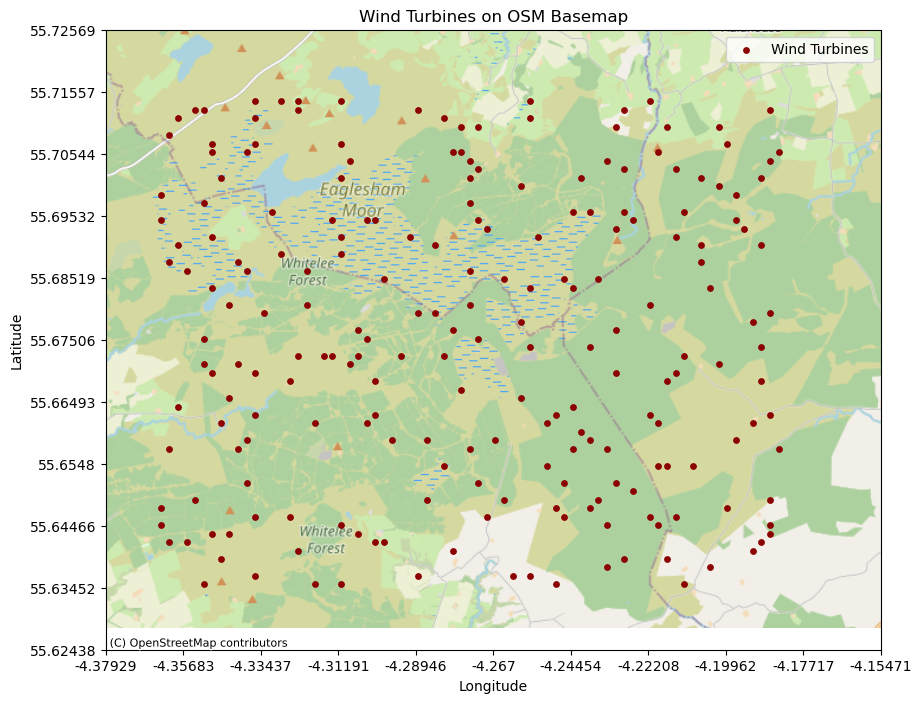

In [6]:
# Create drawings
fig, ax = plt.subplots(figsize=(10, 10))

# Drawing the location of the wind turbine
optimized_gdf.plot(ax=ax, marker='o', color='#8B0000', markersize=15, label='Wind Turbines')

# Add OSM basemap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# Set up legends and captions
ax.legend()
ax.set_title('Wind Turbines on OSM Basemap')

# Axis coordinates converted back to latitude and longitude and formatted for display
def convert_x(x):
    point = gpd.GeoSeries([Point(x, ax.get_ylim()[0])], crs='EPSG:3857').to_crs('EPSG:4326')
    return round(point.x[0], 5)

def convert_y(y):
    point = gpd.GeoSeries([Point(ax.get_xlim()[0], y)], crs='EPSG:3857').to_crs('EPSG:4326')
    return round(point.y[0], 5)

ax.set_xticks(ax.get_xticks())
ax.set_yticks(ax.get_yticks())
ax.set_xticklabels([convert_x(x) for x in ax.get_xticks()])
ax.set_yticklabels([convert_y(y) for y in ax.get_yticks()])

# Setting up axis labels
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Display drawing
plt.show()